In [1]:
%load_ext autoreload
%autoreload 2

### Load libraries and paths

In [2]:
import sys
sys.path.append("../..")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from pySankey.sankey import sankey
import geopandas as gpd
import pymc as pm 
import arviz as az
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from config.config import BASE_PATH, PATH_TO_PATH_CONFIG_FILE, PROJECT_EPSG
from src.utils import load_paths_from_yaml, replace_base_path
from src.modeling.encodings import (convert_aspect_to_cardinal_direction, 
                                    convert_population_to_classes, 
                                    convert_elevation_to_classes, 
                                    convert_slope_to_classes, 
                                    apply_encoding, 
                                    naturraumregionen_encoding, 
                                    map_to_binary)
from src.modeling.utils import temporal_train_test_split, save_model, load_model
from src.modeling.bayesian_models import create_blr, create_st_blr, create_bnn, create_st_intercept_blr
from src.modeling.predictions import BinaryClassification, BinaryClassificationBNN
from src.visualization import (plot_st_sample_size_distribution, plot_performance_over_test_years)


In [4]:
paths = load_paths_from_yaml(PATH_TO_PATH_CONFIG_FILE)
paths = replace_base_path(paths, BASE_PATH)

### Read in data

In [5]:
# read in training data
training_data = gpd.read_file(paths["training_data"])
training_data.date = pd.to_datetime(training_data.date)

# read in Naturraumregionen
naturraumregionen = gpd.read_file(paths["naturraumregionen"])
naturraumregionen.to_crs(PROJECT_EPSG, inplace=True)

In [6]:
training_data.fire.value_counts()

fire
1    1121
0    1116
Name: count, dtype: int64

### Data Cleaning & Preparation

In [7]:
# rename columns
training_data.rename(columns={"farmyard_d": "farmyard_density", 
                              "hiking_ds": "hikingtrail_density", 
                              "forest_ds": "forestroad_density", 
                              "rail_dens": "railway_density", 
                              "foresttype": "forest_type", 
                              "pop_dens": "population_density"}, inplace=True)

training_data = training_data.sjoin(naturraumregionen.loc[:, ["EINHEIT", "geometry"]])
training_data.drop(columns=["index_right"], inplace=True)

training_data['season'] = training_data['date'].dt.month.apply(lambda x: (
    3 if x in [12, 1, 2] else
    0 if x in [3, 4, 5] else
    1 if x in [6, 7, 8] else
    2 
))

# encode features into predefined classes
training_data["naturraumregionen_encoded"] = training_data["EINHEIT"].apply(apply_encoding, mapping=naturraumregionen_encoding)
training_data["elevation_encoded"] = training_data["elevation"].apply(convert_elevation_to_classes)
training_data["slope_encoded"] = training_data["slope"].apply(convert_slope_to_classes)
training_data["aspect_encoded"] = training_data["aspect"].apply(convert_aspect_to_cardinal_direction)
training_data["population_encoded"] = training_data["population_density"].apply(convert_population_to_classes)

# binarize features
training_data["farmyard_density_bin"] = training_data["farmyard_density"].apply(map_to_binary)
training_data["forestroad_density_bin"] = training_data["forestroad_density"].apply(map_to_binary)
training_data["railway_density_bin"] = training_data["railway_density"].apply(map_to_binary)
training_data["hikingtrail_density_bin"] = training_data["hikingtrail_density"].apply(map_to_binary)

# deal with missing data in forest type feature
training_data["forest_type"].fillna(6, inplace=True)
training_data["forest_type"] = training_data["forest_type"].astype(int)

/tmp/ipykernel_120796/2105497721.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_data["forest_type"].fillna(6, inplace=True)


### Temporal train test split

The following gives us the split date:
2016-05-09 00:00:00
2016-05-11 00:00:00


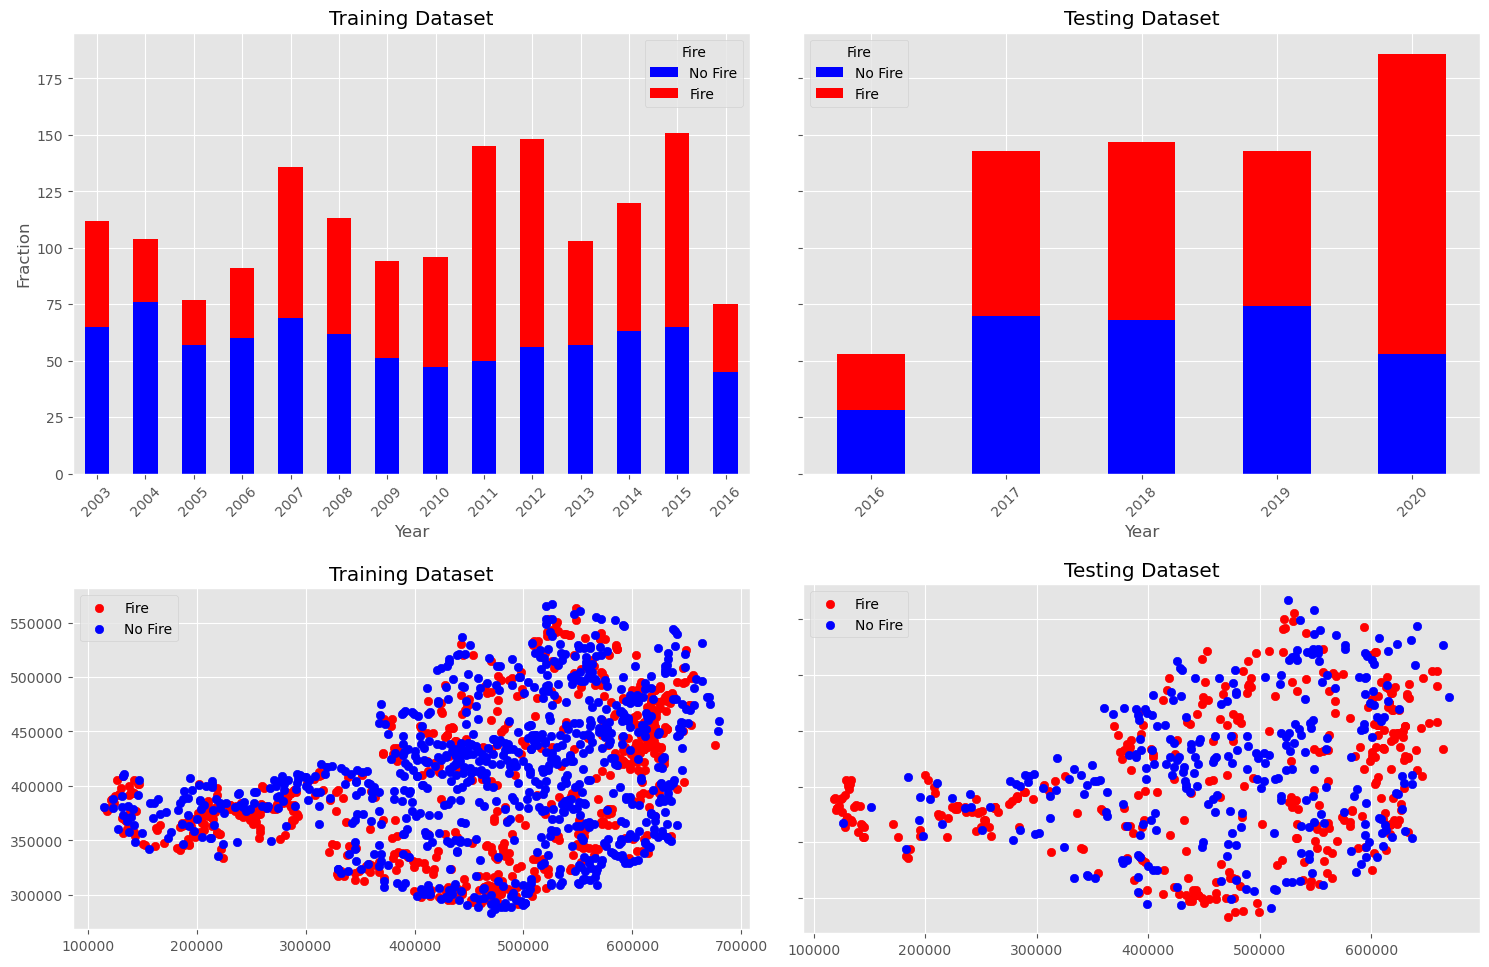

In [8]:
X_train_unprocessed, X_test_unprocessed = temporal_train_test_split(training_data, "date", 0.7)
y_train, y_test = X_train_unprocessed["fire"], X_test_unprocessed["fire"]

print("The following gives us the split date:")
print(X_train_unprocessed.date.max())
print(X_test_unprocessed.date.min())

# Plotting the distribution of fire and no-fire samples for train and test set
plot_st_sample_size_distribution(X_train_unprocessed, X_test_unprocessed, r"../../results/train_test_distribution.png")

### Feature Preprocessing

In [9]:
print(X_train_unprocessed.ffmc.mean())
print(X_train_unprocessed.ffmc.std())

84.90549692757213
6.62969182076025


In [10]:
# feature processing for BLR and ST_BLR
preprocessor_blr = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), ["ffmc"])
    ],
    remainder='drop',
)

preprocessor_blr.fit(X_train_unprocessed)
train_ffmc_scaled = preprocessor_blr.transform(X_train_unprocessed)
test_ffmc_scaled = preprocessor_blr.transform(X_test_unprocessed)

X_train = X_train_unprocessed.copy()
X_test = X_test_unprocessed.copy()
X_train["ffmc"] = train_ffmc_scaled
X_test["ffmc"] = test_ffmc_scaled


features_to_scale = ["ffmc"]
features_to_ohe = ["elevation_encoded", "slope_encoded", "aspect_encoded", 
                   "population_encoded", "farmyard_density_bin", "forestroad_density_bin", 
                   "railway_density_bin", "hikingtrail_density_bin", "forest_type"]

preprocessor_bnn = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), features_to_scale),
        ('ohe', OneHotEncoder(), features_to_ohe)
    ],
    remainder='drop',
)

# scaler
preprocessor_bnn.fit(X_train_unprocessed)
X_train_bnn = preprocessor_bnn.fit_transform(X_train_unprocessed)
X_test_bnn = preprocessor_bnn.transform(X_test_unprocessed)

### Modeling

In [11]:
coords = {"elevation_classes": [0, 1, 2, 3, 4, 5], 
          "slope_classes": [0, 1, 2, 3, 4], 
          "aspect_classes": [0, 1, 2, 3, 4, 5, 6, 7],
          "forest_type_classes": [0, 1, 2, 3, 4, 5, 6], 
          "population_classes": [0, 1, 2, 3, 4, 5], 
          "farmyard_density_classes": [0, 1], 
          "forestroad_density_classes": [0, 1], 
          "railway_density_classes": [0, 1], 
          "hikingtrail_density_classes": [0, 1], 
          "spatial_groups": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
          "temporal_groups": [0, 1, 2, 3]}

In [13]:
# Create simple Bayesian Log Reg Model
model_blr = create_blr(X_train, y_train, coords)
with model_blr:
    approx = pm.fit(n=20000, random_seed=0)
    blr_idata = approx.sample(random_seed=0)

save_model("../../models/blr.pkl", model_blr, blr_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 786.51


In [14]:
model_st_intercept_blr = create_st_intercept_blr(X_train, y_train, coords, "naturraumregionen_encoded", "season")
with model_st_intercept_blr:
    approx = pm.fit(n=20000, random_seed=0)
    st_intercept_blr_idata = approx.sample(random_seed=0)

save_model("../../models/st_intercept_blr.pkl", model_st_intercept_blr, st_intercept_blr_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 775.6


In [15]:
# Spatio temporal Bayesian Logistic Regression Model
model_st_blr = create_st_blr(X_train, y_train, coords, "naturraumregionen_encoded", "season")
with model_st_blr:
    approx = pm.fit(n=20000, random_seed=0)
    st_blr_idata = approx.sample(random_seed=0)

save_model("../../models/st_blr.pkl", model_st_blr, st_blr_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 1,237.4


In [16]:
model_bnn = create_bnn(X_train_bnn.toarray(), y_train)

with model_bnn:
    approx = pm.fit(n=20000, random_seed=0)
    bnn_idata = approx.sample(random_seed=0)

save_model("../../models/bnn.pkl", model_bnn, bnn_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:416: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


Output()

Finished [100%]: Average Loss = 1,076.8


### Out-of-sample prediction

In [11]:
# open saved models
model_blr, idata_blr = load_model("../../models/blr.pkl")
model_st_blr, idata_st_blr = load_model("../../models/st_blr.pkl")
model_st_intercept_blr, idata_st_intercept_blr = load_model("../../models/st_intercept_blr.pkl")
model_bnn, idata_bnn = load_model("../../models/bnn.pkl")

In [12]:
y_dummy = [0 for i in y_test]
X_new_blr = {
    "elevation": X_test.elevation_encoded,
    "slope": X_test.slope_encoded,
    "aspect": X_test.aspect_encoded,
    "forestroad_density": X_test.forestroad_density_bin,
    "railway_density": X_test.railway_density_bin,
    "hikingtrail_density": X_test.hikingtrail_density_bin,
    "farmyard_density": X_test.farmyard_density_bin,
    "population": X_test.population_encoded,
    "forest_type": X_test.forest_type,
    "ffmc": X_test.ffmc,
    "fire": y_dummy
    }

X_new_st_blr = X_new_blr.copy()
X_new_st_blr["spatial_groups_idx"] = X_test.naturraumregionen_encoded
X_new_st_blr["temporal_groups_idx"] = X_test.season

In [13]:
seed = 0

# predictions for blr model
blr_prediction_obj = BinaryClassification(model_blr, idata_blr, X_new_blr, seed, "y_pred", "p", "z")
blr_prediction_obj.extend_trace()
blr_preds = blr_prediction_obj.predict()

# predictions for st_intercept_blr model
st_intercept_blr_prediction_obj = BinaryClassification(model_st_intercept_blr, idata_st_intercept_blr, X_new_st_blr, seed, "y_pred", "p", "z")
st_intercept_blr_prediction_obj.extend_trace()
st_intercept_blr_preds = st_intercept_blr_prediction_obj.predict()

# predictions for st_blr model
st_blr_prediction_obj = BinaryClassification(model_st_blr, idata_st_blr, X_new_st_blr, seed, "y_pred", "p", "z")
st_blr_prediction_obj.extend_trace()
st_blr_preds = st_blr_prediction_obj.predict()

# predictions for bnn model
bnn_prediction_obj = BinaryClassificationBNN(model_bnn, idata_bnn, X_test_bnn.toarray(), seed, "y_pred", "p")
bnn_prediction_obj.extend_trace()
bnn_preds = bnn_prediction_obj.predict()


Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

### Analyze & Visualize results

#### Calculate overall model performance

In [14]:

print("BLR Accuracy: ", round(accuracy_score(y_test, blr_preds.y_pred), 2))
print("BLR Precision: ", round(precision_score(y_test, blr_preds.y_pred), 2))
print("BLR Recall: ", round(recall_score(y_test, blr_preds.y_pred), 2))
print("BLR F1 Score", round(f1_score(y_test, blr_preds.y_pred), 2))

print("---------------------------------")

print("ST Intercept BLR Accuracy: ", round(accuracy_score(y_test, st_intercept_blr_preds.y_pred), 2))
print("ST Intercept BLR Precision: ", round(precision_score(y_test, st_intercept_blr_preds.y_pred), 2))
print("ST Intercept BLR  Recall: ", round(recall_score(y_test, st_intercept_blr_preds.y_pred), 2))
print("ST Intercept BLR  F1 Score: ", round(f1_score(y_test, st_intercept_blr_preds.y_pred), 2))


print("---------------------------------")

print("ST BLR Accuracy: ", round(accuracy_score(y_test, st_blr_preds.y_pred), 2))
print("ST BLR Precision: ", round(precision_score(y_test, st_blr_preds.y_pred), 2))
print("ST BLR Recall: ", round(recall_score(y_test, st_blr_preds.y_pred), 2))
print("ST BLR F1 Score: ", round(f1_score(y_test, st_blr_preds.y_pred), 2))


print("---------------------------------")

print("BNN Accuracy: ", round(accuracy_score(y_test, bnn_preds.y_pred), 2))
print("BNN Precision: ", round(precision_score(y_test, bnn_preds.y_pred), 2))
print("BNN Recall: ", round(recall_score(y_test, bnn_preds.y_pred), 2))
print("BNN F1 Score: ", round(f1_score(y_test, bnn_preds.y_pred), 2))



BLR Accuracy:  0.77
BLR Precision:  0.83
BLR Recall:  0.75
BLR F1 Score 0.79
---------------------------------
ST Intercept BLR Accuracy:  0.77
ST Intercept BLR Precision:  0.82
ST Intercept BLR  Recall:  0.75
ST Intercept BLR  F1 Score:  0.79
---------------------------------
ST BLR Accuracy:  0.75
ST BLR Precision:  0.79
ST BLR Recall:  0.76
ST BLR F1 Score:  0.78
---------------------------------
BNN Accuracy:  0.77
BNN Precision:  0.8
BNN Recall:  0.79
BNN F1 Score:  0.8


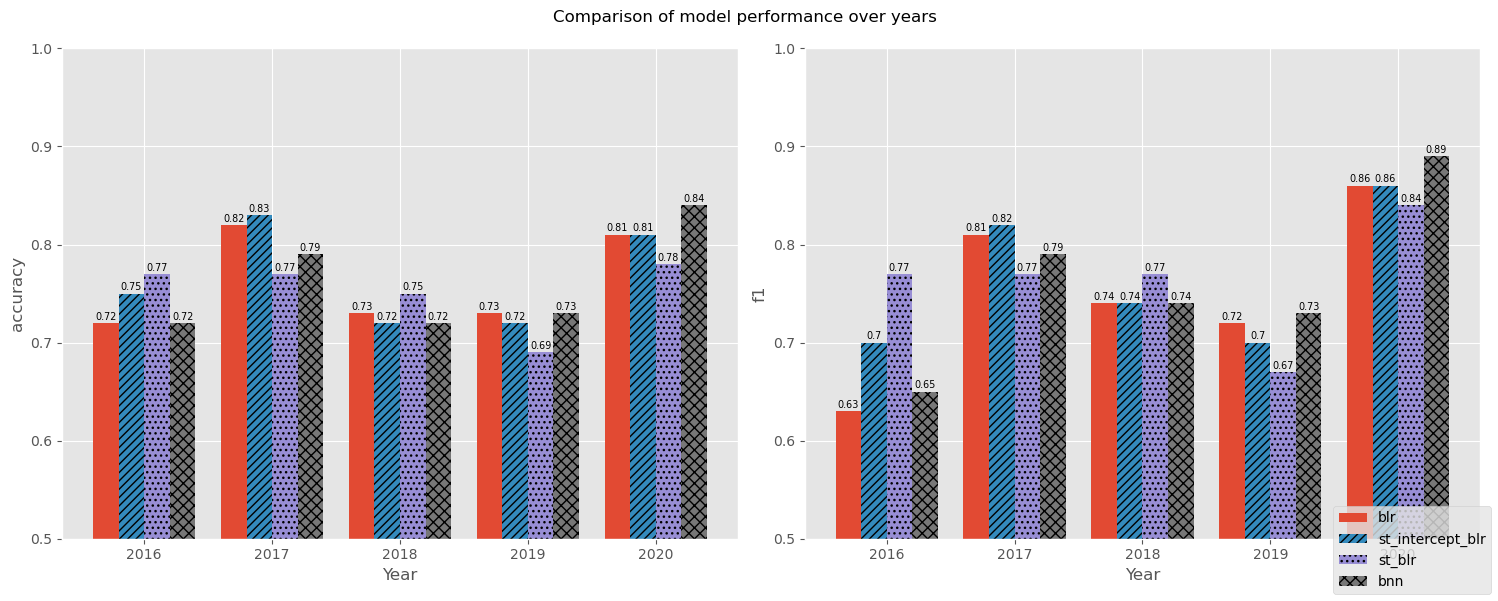

In [15]:
# Performance (Accuracy & F1) over years and across seasons (4 plots)
model_preds = [(blr_preds, "blr"), (st_intercept_blr_preds, "st_intercept_blr"), (st_blr_preds, "st_blr"), (bnn_preds, "bnn")]
plot_performance_over_test_years(model_preds, X_test, y_test, "../../results/model_performance_over_years.png")

#### Plot spatio-temporal model performance

/tmp/ipykernel_120796/1527691737.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  preds_spatial_grouped = preds.groupby(["spatial_group"]).apply(calculate_st_metrics).reset_index()
/tmp/ipykernel_120796/1527691737.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  preds_temporal_grouped = preds.groupby(["temporal_group"]).apply(calculate_st_metrics).reset_index()


,temporal_group,accuracy,f1,sample_size
0,0,0.766756,0.800000,373.0
1,1,0.731250,0.736196,160.0
2,2,0.800000,0.777778,60.0
3,3,0.835443,0.826667,79.0


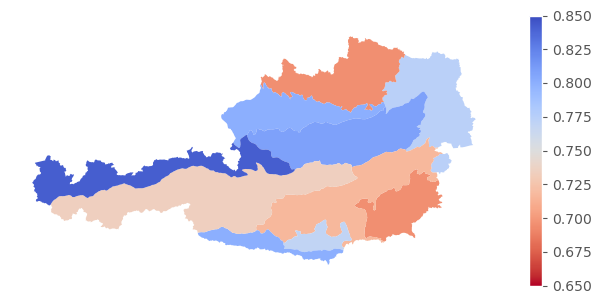

In [16]:
spatial_groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
temporal_groups = [0, 1, 2, 3]
naturraumregionen["EINHEIT_encoded"] = naturraumregionen["EINHEIT"].apply(apply_encoding, mapping=naturraumregionen_encoding)

#preds = st_intercept_blr_preds.copy()
preds = st_intercept_blr_preds.copy()

preds["spatial_group"] = X_test.naturraumregionen_encoded.values
preds["temporal_group"] = X_test.season.values
preds["y_true"] = y_test.values

def calculate_st_metrics(group):
    accuracy = accuracy_score(group['y_true'], group['y_pred'])
    f1 = f1_score(group['y_true'], group['y_pred'])
    sample_size = len(group)
    return pd.Series({'accuracy': accuracy, 'f1': f1, 'sample_size': sample_size})

preds_spatial_grouped = preds.groupby(["spatial_group"]).apply(calculate_st_metrics).reset_index()

gdf = pd.merge(naturraumregionen, preds_spatial_grouped, left_on="EINHEIT_encoded", right_on="spatial_group")
gdf.plot(column="accuracy", cmap="coolwarm_r", vmin=0.65, vmax=0.85, legend=True, legend_kwds={"shrink":0.6} )
plt.axis("off")
plt.tight_layout()
plt.savefig("../../results/model_performance_regions_blr.png")

preds_temporal_grouped = preds.groupby(["temporal_group"]).apply(calculate_st_metrics).reset_index()
preds_temporal_grouped


#### Uncertainty Quantification

##### Summary Statistics 

In [17]:
X_train.columns

Index(['index', 'date', 'Pufferradi', 'fire', 'year', 'month', 'day',
       'farmyard_density', 'hikingtrail_density', 'forestroad_density',
       'railway_density', 'elevation', 'slope', 'aspect', 'forest_type',
       'canopy_cov', 'population_density', 'ffmc', 'geometry', 'EINHEIT',
       'season', 'naturraumregionen_encoded', 'elevation_encoded',
       'slope_encoded', 'aspect_encoded', 'population_encoded',
       'farmyard_density_bin', 'forestroad_density_bin', 'railway_density_bin',
       'hikingtrail_density_bin'],
      dtype='object')

In [18]:
X_train.Pufferradi = X_train.Pufferradi.astype("float")

agg_df = X_train.groupby('population_encoded').agg(
    total_fire=('fire', 'sum'),
    sample_count=('fire', 'count'),
    mean_pufferradi=('Pufferradi', 'mean')
).reset_index()

agg_df["mean_pufferradi"] = agg_df["mean_pufferradi"].round(0)
agg_df['fire_to_sample_ratio'] = (agg_df['total_fire'] / agg_df['sample_count']).round(2)

var_hdi = az.hdi(idata_st_intercept_blr.posterior["beta_population"][:, :, :].values, hdi_prob=0.95)
var_mean = idata_st_intercept_blr.posterior["beta_population"][:, :, :].values.mean(axis=(0, 1))

agg_df["coeff"] = var_mean
agg_df["hdi_width"] = (var_hdi[:, 1] - var_hdi[:, 0]).round(2)

agg_df

#print(agg_df.hdi_width.corr(agg_df.mean_pufferradi))
#print(agg_df.hdi_width.corr(agg_df.sample_count))

,population_encoded,total_fire,sample_count,mean_pufferradi,fire_to_sample_ratio,coeff,hdi_width
0,0,133,565,288.0,0.24,-1.317473,0.61
1,1,192,437,296.0,0.44,-0.301012,0.63
2,2,90,153,281.0,0.59,0.554486,0.85
3,3,193,259,287.0,0.75,1.262833,0.80
4,4,59,69,312.0,0.86,1.638508,1.63
5,5,75,82,266.0,0.91,1.555131,1.82


##### Intercept

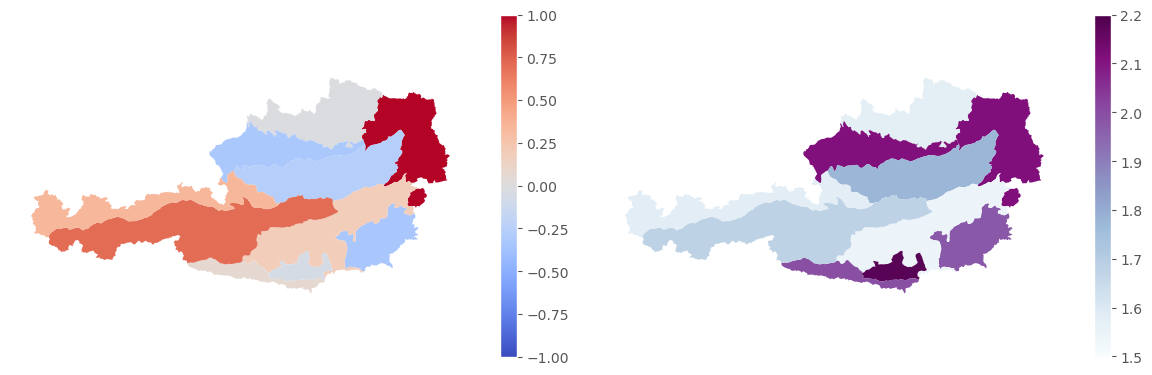

In [19]:
hdi_intercept_regions = az.hdi(idata_st_intercept_blr.posterior.intercept[:, :, :, :].values, hdi_prob=0.95).mean(axis=1)
hdi_intercept_mean = idata_st_intercept_blr.posterior.intercept[:, :, :, :].values.mean(axis=(0, 1, 3))
hdi_width = np.abs(hdi_intercept_regions[:, 1] - hdi_intercept_regions[:, 0])
hdi_regions_df = pd.DataFrame({"hdi_intercept_lower": hdi_intercept_regions[:, 0],
             "hdi_intercept_upper": hdi_intercept_regions[:, 1],
             "hdi_intercept_mean": hdi_intercept_mean,
             "hdi_intercept_width": hdi_width,
             "EINHEIT": naturraumregionen_encoding.keys()
             })
hdi_regions_gdf = pd.merge(naturraumregionen, hdi_regions_df, on="EINHEIT")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
hdi_plot1 = hdi_regions_gdf.plot(column="hdi_intercept_mean", cmap="coolwarm", legend=True, vmin=-1, vmax=1, ax=ax1, legend_kwds={"shrink": 0.6})
ax1.axis('off')
hdi_plot2 = hdi_regions_gdf.plot(column="hdi_intercept_width", cmap="BuPu", legend=True, vmin=1.5, vmax=2.2, ax=ax2, legend_kwds={"shrink": 0.6})
ax2.axis('off')

plt.tight_layout()
#plt.savefig("../../results/hdi_intercept_mean_and_hdi_width.png")
#plt.show()

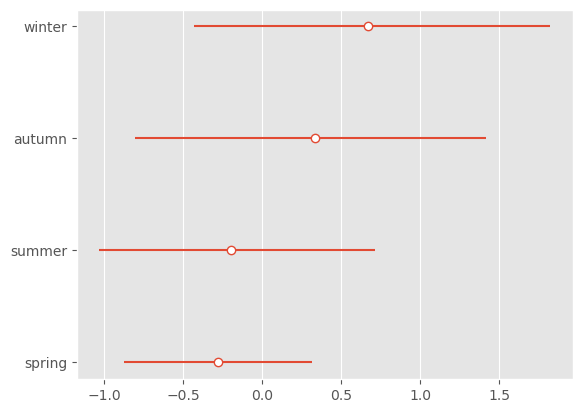

In [20]:
intercept_seasons_hdi = az.hdi(idata_st_intercept_blr.posterior.intercept[:, :, :, :].values, hdi_prob=0.95).mean(axis=0)
intercept_seasons_mean = idata_st_intercept_blr.posterior.intercept[:, :, :, :].values.mean(axis=(0, 1, 2))

error_upper = np.abs(intercept_seasons_hdi[:, 1] - intercept_seasons_mean)
error_lower = np.abs(intercept_seasons_hdi[:, 0] - intercept_seasons_mean)
plt.errorbar(x=intercept_seasons_mean, y=["spring", "summer", "autumn", "winter"], xerr=np.array([error_lower, error_upper]), fmt='o', markerfacecolor='white')
plt.grid(axis='y', which='both', linestyle='')
plt.savefig("../../results/hdi_intercept_mean_and_hdi_seasons.png")

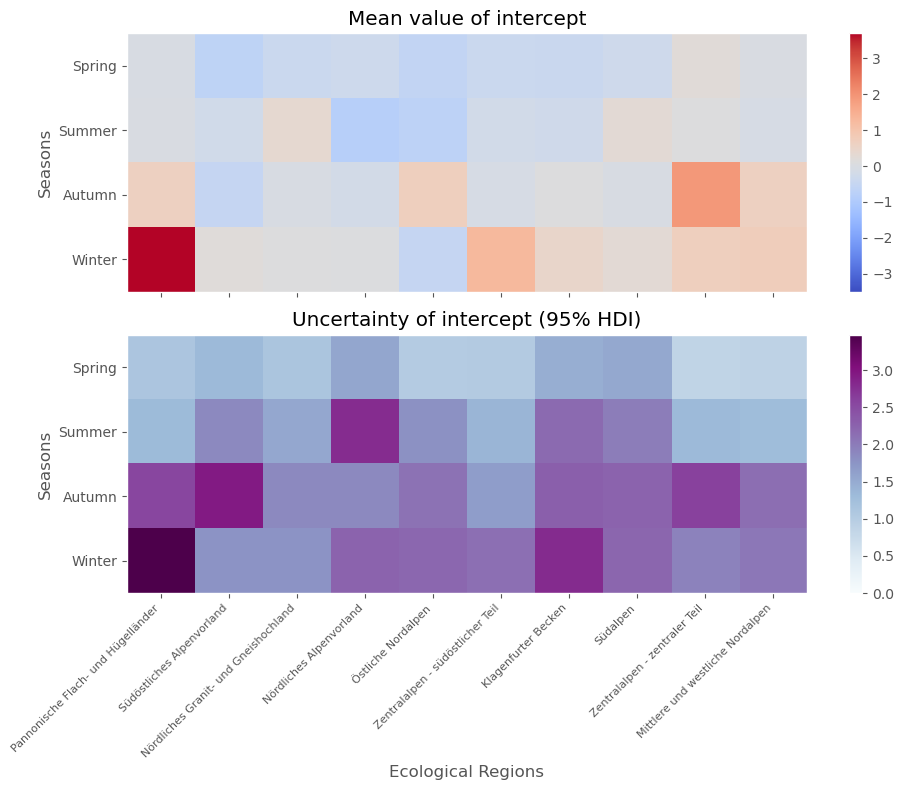

In [21]:
region_names = list(naturraumregionen_encoding.keys())
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']

# Assuming hdi_intercept and idata_st_intercept_blr are already defined
hdi_intercept = az.hdi(idata_st_intercept_blr.posterior.intercept.values, hdi_prob=0.95)
hdi_width = hdi_intercept[:, :, 1] - hdi_intercept[:, :, 0]
hdi_mean = hdi_intercept.mean(axis=2)

# Plot configuration
fig, axs = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)

# First plot: HDI Mean
axs[0].imshow(hdi_mean.T, cmap='coolwarm', aspect='auto', vmin=-3.5, vmax=3.7)
axs[0].set_title('Mean value of intercept')
axs[0].set_ylabel('Seasons')

# Second plot: HDI Width
cax = axs[1].imshow(hdi_width.T, cmap='BuPu', aspect='auto', vmin=0)
axs[1].set_title('Uncertainty of intercept (95% HDI)')
axs[1].set_xlabel('Ecological Regions')
axs[1].set_ylabel('Seasons')

# Shared configuration
for ax in axs:
    ax.set_xticks(np.arange(hdi_mean.shape[0]))  # Regions
    ax.set_yticks(np.arange(hdi_mean.shape[1]))  # Seasons
    ax.set_xticks(np.arange(len(region_names)))
    ax.set_xticklabels(region_names, rotation=45, ha="right")
    ax.set_yticks(np.arange(len(seasons)))
    ax.set_yticklabels(seasons)
    ax.grid(False)
    fig.colorbar(ax.images[0], ax=ax)  # Add colorbar to each plot

ax.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()
plt.savefig("../../results/hdi_intercept_spatial_and_temporal.png")
plt.show()

##### Feature Coefficients & Uncertainty

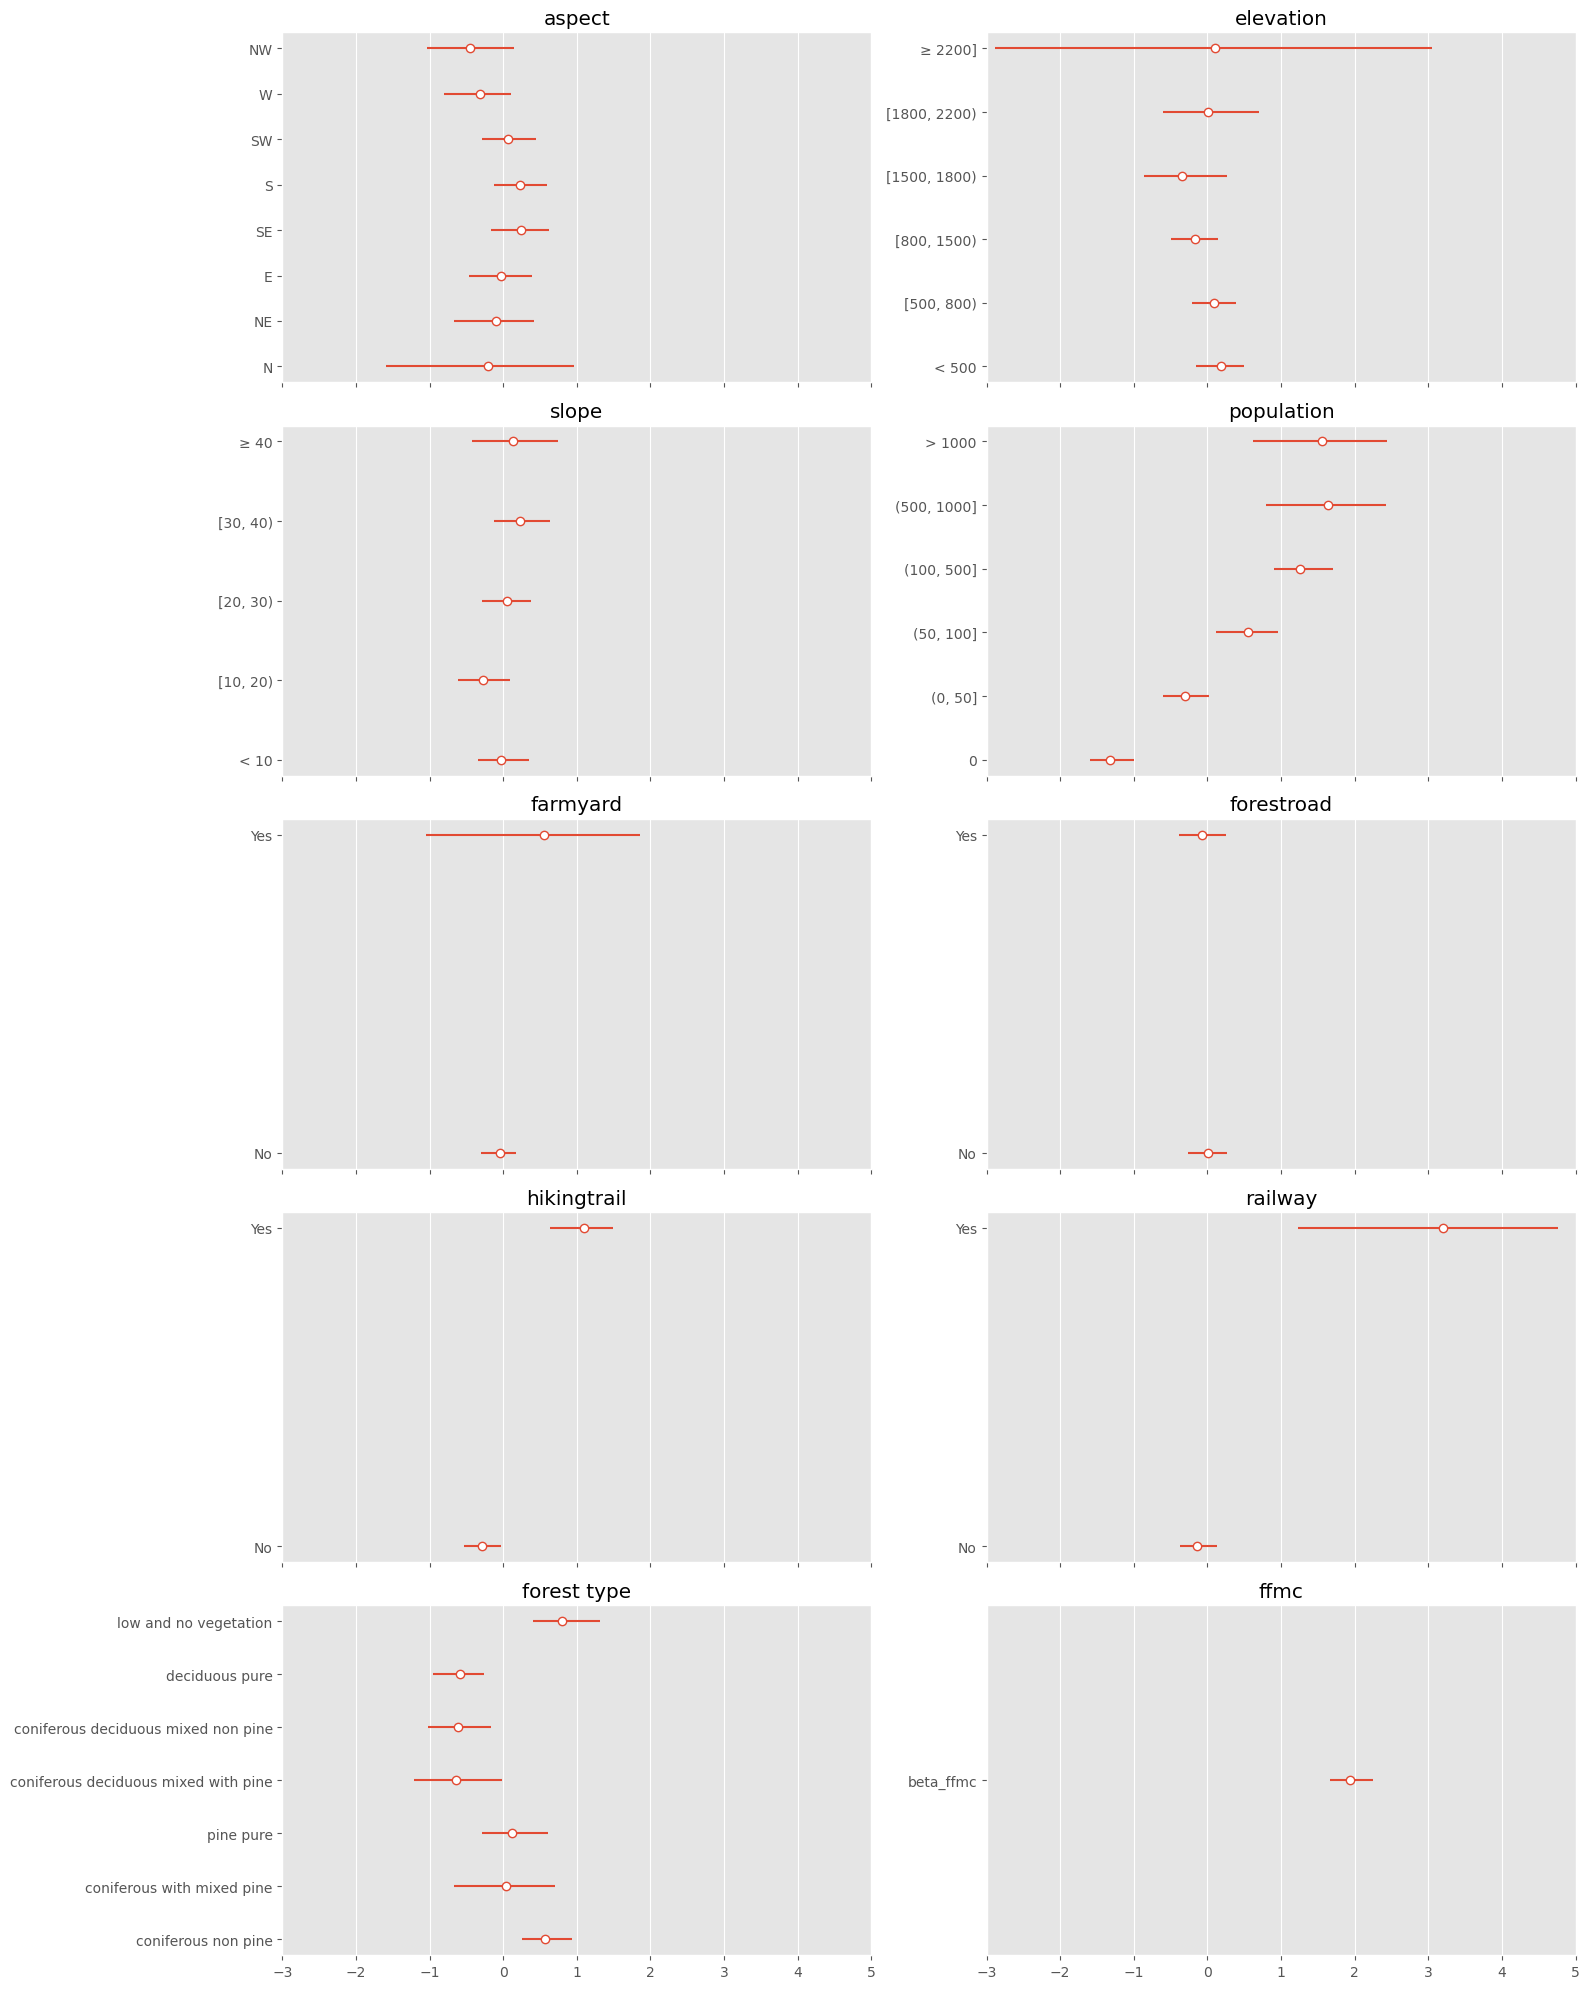

In [22]:
idata_data = idata_st_intercept_blr.copy()

var_dict = {
    "beta_aspect": ("aspect", ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]),
    "beta_elevation": ("elevation", ["< 500", "[500, 800)", "[800, 1500)", "[1500, 1800)", "[1800, 2200)", "≥ 2200]"]),
    "beta_slope": ("slope", ["< 10", "[10, 20)", "[20, 30)", "[30, 40)", "≥ 40"]),
    "beta_population": ("population", ["0", "(0, 50]", "(50, 100]", "(100, 500]", "(500, 1000]", "> 1000"]),
    "beta_farmyard_density": ("farmyard", ["No", "Yes"]),
    "beta_forestroad_density": ("forestroad", ["No", "Yes"]),
    "beta_hikingtrail_density": ("hikingtrail", ["No", "Yes"]),
    "beta_railway_density": ("railway", ["No", "Yes"]),
    "beta_forest_type": ("forest type", ["coniferous non pine", "coniferous with mixed pine", "pine pure", "coniferous deciduous mixed with pine", "coniferous deciduous mixed non pine", "deciduous pure", "low and no vegetation"]),
    "beta_ffmc": ("ffmc", ["beta_ffmc"])
}


num_vars = len(var_dict)
fig, axes = plt.subplots(int(num_vars / 2), 2, figsize=(16, 2 * num_vars), sharex=True)

axs = axes.flatten()

for i, (var, var_classes) in enumerate(var_dict.items()):

    if var == "beta_ffmc":
        var_hdi = az.hdi(idata_data.posterior["beta_ffmc"], hdi_prob=0.95).beta_ffmc.values
        var_mean = idata_data.posterior["beta_ffmc"][:, :].values.mean(axis=(0, 1))
        error_upper = [np.abs(var_hdi[1] - var_mean)]
        error_lower = [np.abs(var_hdi[0] - var_mean)]
    else:
        var_hdi = az.hdi(idata_data.posterior[var][:, :, :].values, hdi_prob=0.95)
        var_mean = idata_data.posterior[var][:, :, :].values.mean(axis=(0, 1))
        error_upper = np.abs(var_hdi[:, 1] - var_mean)
        error_lower = np.abs(var_hdi[:, 0] - var_mean)
    
    axs[i].errorbar(x=var_mean, y=np.arange(len(var_classes[1])), 
                    xerr=np.array([error_lower, error_upper]), 
                    fmt='o', markerfacecolor='white')
    axs[i].set_xlim(-3, 5)
    axs[i].grid(axis='y', which='both', linestyle='')
    axs[i].set_yticks(np.arange(len(var_classes[1])))
    axs[i].set_yticklabels(var_classes[1])
    axs[i].set_title(var_classes[0])
    
plt.tight_layout()
plt.savefig("../../results/hdi_features_st_blr_intercept.png")
plt.show()

##### Uncertainty of predictions

In [58]:
relevant_columns = ['index', 'date', 'Pufferradi', 'forest_type',
                    'season', 'naturraumregionen_encoded', 'ffmc', 'ffmc_unscaled', 'elevation_encoded',
                    'slope_encoded', 'aspect_encoded', 'population_encoded',
                    'farmyard_density_bin', 'forestroad_density_bin', 'railway_density_bin',
                    'hikingtrail_density_bin', 'fire', 'y_pred', 'p_pred',
                    'p_hdi_width', 'z_pred', 'z_hdi_lower', 'z_hdi_upper', 'z_hdi_width', 'z_pred_stdscaled', 'z_hdi_upper_stdscaled', 'z_hdi_lower_stdscaled', 'z_hdi_width_stdscaled']

In [59]:
z_value_train_mean = idata_st_intercept_blr.posterior.z.values.mean()
z_value_train_std = idata_st_intercept_blr.posterior.z.values.std()

print(z_value_train_mean, z_value_train_std)

def z_score_normalize(value: float, mean: float, std: float):
    return (value - mean) / std 

-0.2822906402545993 2.902846208513572


In [60]:
data = pd.concat([X_test.reset_index(drop=True), st_intercept_blr_preds], axis=1)

data["z_pred_stdscaled"] = data["z_pred"].apply(lambda x: z_score_normalize(x, z_value_train_mean, z_value_train_std)).round(3)
data["z_hdi_upper_stdscaled"] = data["z_hdi_upper"].apply(lambda x: z_score_normalize(x, z_value_train_mean, z_value_train_std))
data["z_hdi_lower_stdscaled"] = data["z_hdi_lower"].apply(lambda x: z_score_normalize(x, z_value_train_mean, z_value_train_std))
data["z_hdi_width_stdscaled"] = (data["z_hdi_upper_stdscaled"] - data["z_hdi_lower_stdscaled"]).round(3)


data["ffmc_unscaled"] = preprocessor_blr.named_transformers_['std_scaler'].inverse_transform(data.loc[:, ["ffmc"]])
data["p_pred"] = data["p_pred"].round(3)
data["p_hdi_width"] = data["p_hdi_width"].round(3)

data = data.loc[:, relevant_columns]
data.head()

,index,date,Pufferradi,forest_type,season,naturraumregionen_encoded,ffmc,ffmc_unscaled,elevation_encoded,slope_encoded,...,p_pred,p_hdi_width,z_pred,z_hdi_lower,z_hdi_upper,z_hdi_width,z_pred_stdscaled,z_hdi_upper_stdscaled,z_hdi_lower_stdscaled,z_hdi_width_stdscaled
0,437,2016-05-11,200,0,0,8,0.123060,85.721085,2,1,...,0.481,0.502,-0.080167,-1.093459,1.114719,2.208178,0.070,0.481255,-0.279439,0.761
1,439,2016-05-11,150,6,0,5,-0.725684,80.095970,3,0,...,0.140,0.266,-1.950667,-3.188437,-0.761098,2.427339,-0.575,-0.164944,-1.001137,0.836
2,438,2016-05-11,100,5,0,8,0.174000,86.058693,3,3,...,0.162,0.295,-1.759634,-2.863848,-0.524788,2.339061,-0.509,-0.083538,-0.889319,0.806
3,436,2016-05-19,250,4,0,9,-0.384439,82.357597,1,1,...,0.605,0.599,0.477260,-1.085929,1.885206,2.971135,0.262,0.746680,-0.276845,1.024
4,2189,2016-05-21,None,4,0,5,0.496526,88.196259,1,1,...,0.275,0.394,-1.043675,-2.163183,0.007280,2.170463,-0.262,0.099754,-0.647948,0.748


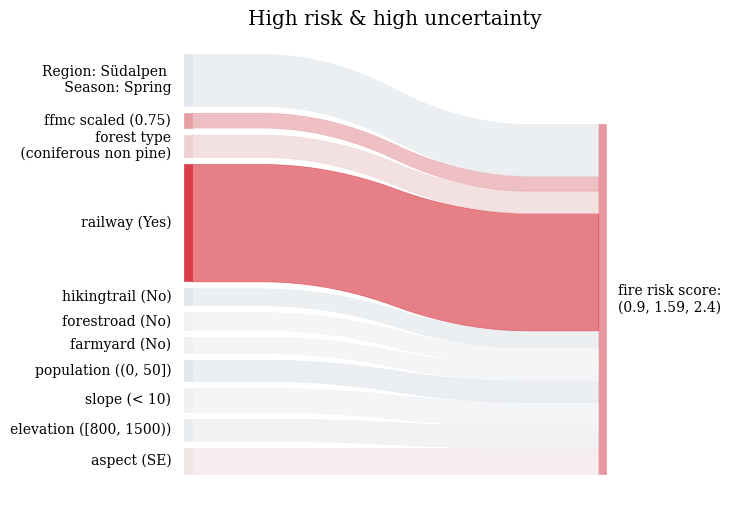

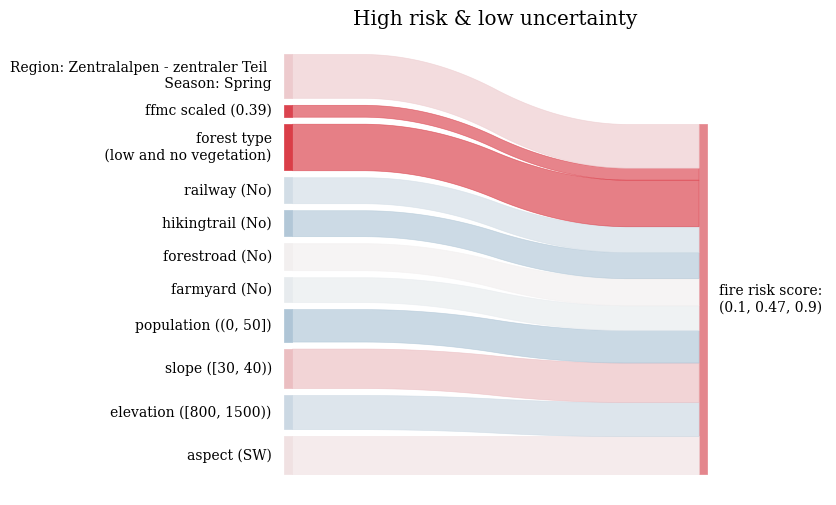

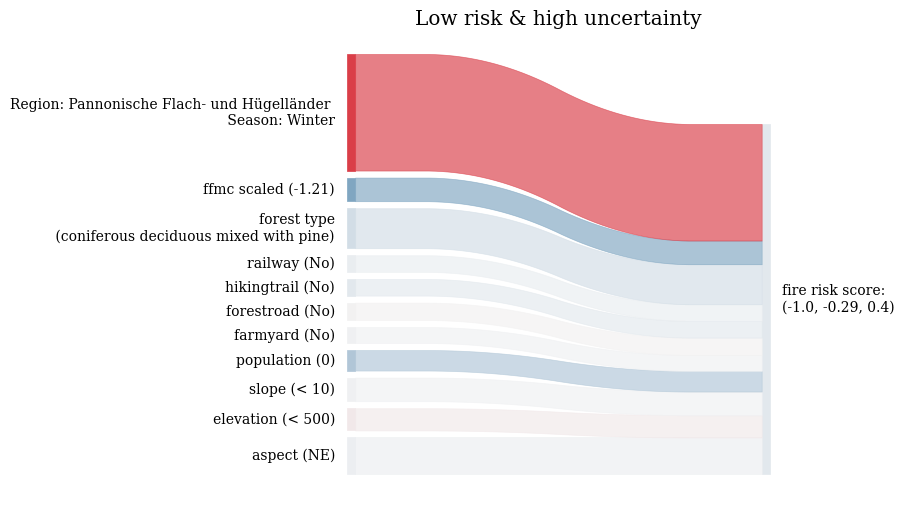

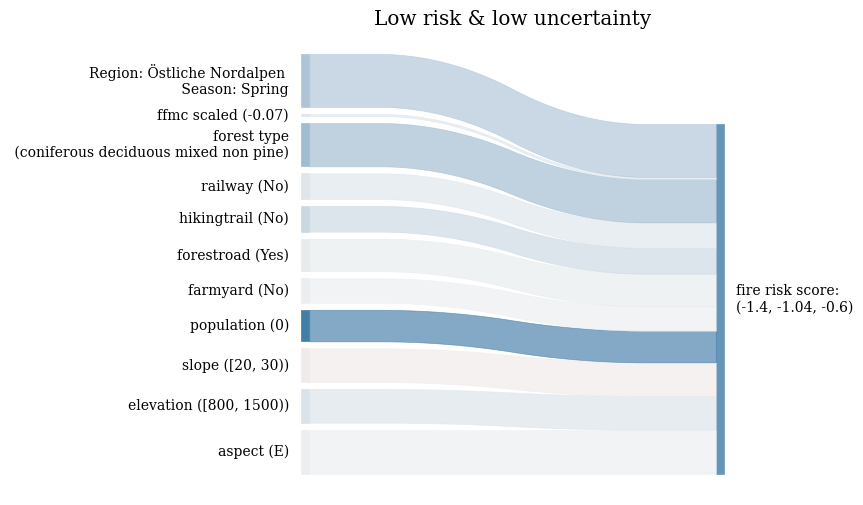

In [26]:
seed = 3

sample_high_risk_high_uncertainty = data[(data.z_pred_stdscaled > 0) & (data.z_hdi_width_stdscaled > 1.4)].sample(1, random_state=seed).index.values[0]
sample_high_risk_low_uncertainty = data[(data.z_pred_stdscaled > 0) & (data.z_hdi_width_stdscaled < 0.8)].sample(1, random_state=seed).index.values[0]
sample_low_risk_high_uncertainty = data[(data.z_pred_stdscaled < 0) & (data.z_hdi_width_stdscaled > 1.4)].sample(1, random_state=seed).index.values[0]
sample_low_risk_low_uncertainty = data[(data.z_pred_stdscaled < 0) & (data.z_hdi_width_stdscaled < 0.8)].sample(1, random_state=seed).index.values[0]

sample_ids = {"High risk & high uncertainty": sample_high_risk_high_uncertainty, 
              "High risk & low uncertainty": sample_high_risk_low_uncertainty, 
              "Low risk & high uncertainty": sample_low_risk_high_uncertainty, 
              "Low risk & low uncertainty": sample_low_risk_low_uncertainty}

var_dict = {
    "beta_aspect": ("aspect_encoded", ["N", "NE", "E", "SE", "S", "SW", "W", "NW"], "aspect"),
    "beta_elevation": ("elevation_encoded", ["< 500", "[500, 800)", "[800, 1500)", "[1500, 1800)", "[1800, 2200)", "≥ 2200]"], "elevation"),
    "beta_slope": ("slope_encoded", ["< 10", "[10, 20)", "[20, 30)", "[30, 40)", "≥ 40"], "slope"),
    "beta_population": ("population_encoded", ["0", "(0, 50]", "(50, 100]", "(100, 500]", "(500, 1000]", "> 1000"], "population"),
    "beta_farmyard_density": ("farmyard_density_bin", ["No", "Yes"], "farmyard"),
    "beta_forestroad_density": ("forestroad_density_bin", ["No", "Yes"], "forestroad"),
    "beta_hikingtrail_density": ("hikingtrail_density_bin", ["No", "Yes"], "hikingtrail"),
    "beta_railway_density": ("railway_density_bin", ["No", "Yes"], "railway"),
    "beta_forest_type": ("forest_type", ["coniferous non pine", "coniferous with mixed pine", "pine pure", "coniferous deciduous mixed with pine", "coniferous deciduous mixed non pine", "deciduous pure", "low and no vegetation"], "forest type"),
    "beta_ffmc": ("ffmc", [], "ffmc scaled")
}


for scenario in sample_ids:

    example_id = sample_ids[scenario]

    # Define a colormap using seaborn's diverging_palette, with blue for negative and red for positive
    palette = sns.diverging_palette(240, 10, n=100, as_cmap=True)

    # Create the rows as before
    rows = []

    for key in var_dict:
        var_name = var_dict[key][2]
        category_id = data.loc[example_id, var_dict[key][0]]

        if key != "beta_ffmc":
            feature_coefficient = idata_st_intercept_blr.posterior[key][0, :, category_id].values.mean()
            feature_category_hdi = az.hdi(idata_st_intercept_blr.posterior[key][0, :, category_id].values)
            feature_name = var_dict[key][1][category_id]
            hdi_width = (feature_category_hdi[1] - feature_category_hdi[0]).round(2)
        else:
            feature_coefficient = idata_st_intercept_blr.posterior[key][0, :].values.mean()
            feature_coefficient = feature_coefficient * category_id
            feature_category_hdi = az.hdi(idata_st_intercept_blr.posterior[key][0, :].values)
            hdi_width = (feature_category_hdi[1] * np.abs(category_id)) - (feature_category_hdi[0] * np.abs(category_id))
            hdi_width = hdi_width.round(2)
            feature_name = category_id.round(2)

        if var_name == "forest type":
            rows.append({"factor": f"{var_name}\n ({feature_name})", "uncertainty_value": hdi_width, "coefficient_value": feature_coefficient})
        else:
            rows.append({"factor": f"{var_name} ({feature_name})", "uncertainty_value": hdi_width, "coefficient_value": feature_coefficient})

    region_id = data.loc[example_id, "naturraumregionen_encoded"]
    season_id = data.loc[example_id, "season"]
    intercept_coefficient = idata_st_intercept_blr.posterior.intercept[0, :, region_id, season_id].values.mean()
    intercept_hdi = az.hdi(idata_st_intercept_blr.posterior.intercept[0, :, region_id, season_id].values)
    intercept_hdi_width = (intercept_hdi[1] - intercept_hdi[0]).round(2)
    region_name = list(naturraumregionen_encoding.keys())[region_id]
    rows.append({"factor": f"Region: {region_name} \n Season: {seasons[season_id]}", "uncertainty_value": intercept_hdi_width, "coefficient_value": intercept_coefficient})

    df = pd.DataFrame(rows)
    z_hdi_lower_scaled = data.loc[example_id, "z_hdi_lower_stdscaled"].round(1)
    z_hdi_upper_scaled = data.loc[example_id, "z_hdi_upper_stdscaled"].round(1)
    z_pred_scaled = data.loc[example_id, "z_pred_stdscaled"].round(2)
    df["target"] = f"fire risk score: \n{z_hdi_lower_scaled, z_pred_scaled, z_hdi_upper_scaled}"

    # Create a color dictionary based on the values of z_pred_scaled
    colors = {}

    for row in df.iterrows():
        # Normalize z_pred_scaled to be between 0 and 1

        if np.abs(df.coefficient_value.min()) >= np.abs(df.coefficient_value.max()):
            vmin = df.coefficient_value.min()
            vmax = np.abs(df.coefficient_value.min())
        else:
            vmin = -df.coefficient_value.max()
            vmax = df.coefficient_value.max()

        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        color_value = norm(row[1].coefficient_value)
        
        # Get the color from the palette and convert it to a hex code
        rgba_color = palette(color_value)
        hex_color = mcolors.to_hex(rgba_color)
        
        # Assign the hex color to the factor
        colors[row[1].factor] = hex_color

    color_value_target = norm(z_pred_scaled)
    rgba_color_target = palette(color_value_target)
    hex_color_target = mcolors.to_hex(rgba_color_target)
    colors[df.target[0]] = hex_color_target



    # Plotting the Sankey with the dynamically assigned hex colors
    sankey(
        left=df["factor"], right=df["target"], 
        leftWeight= df["uncertainty_value"], fontsize=10,
        colorDict=colors
    )

    plt.title(scenario)
    #plt.savefig(f"../../results/example_{scenario}.png", bbox_inches="tight", dpi=300)
    plt.show()

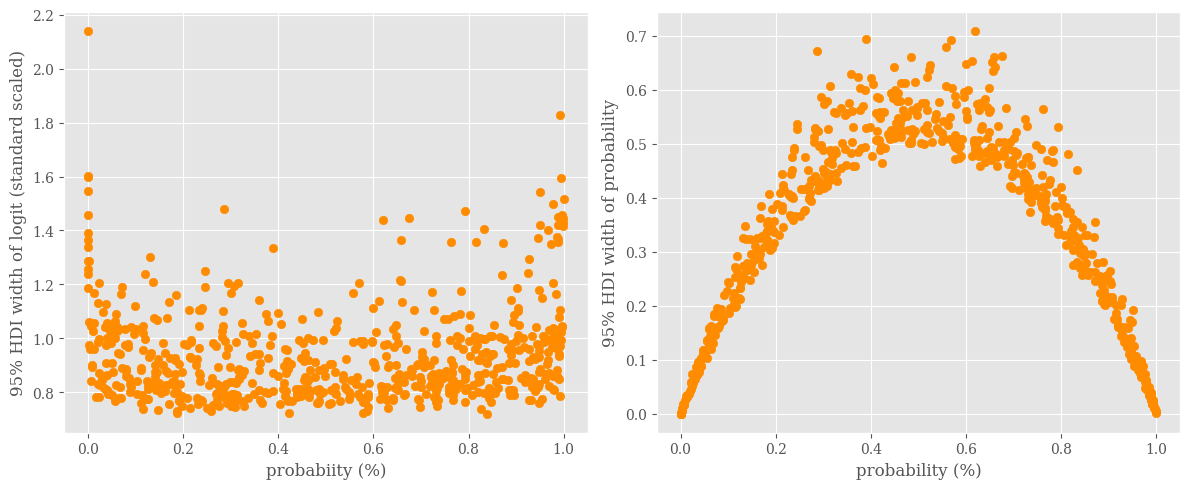

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(data["p_pred"], data["z_hdi_width_stdscaled"], color="darkorange")
ax1.set_xlabel('probabiity (%)')
ax1.set_ylabel('95% HDI width of logit (standard scaled)')

ax2.scatter(data["p_pred"], data["p_hdi_width"], color="darkorange")
ax2.set_xlabel('probability (%)')
ax2.set_ylabel('95% HDI width of probability')

plt.savefig("../../results/uncertainty_risk_distribution.png")

plt.tight_layout()
plt.show()

#### Insights from model uncertainty for model improvement

In [50]:
X_train.groupby(["naturraumregionen_encoded", "season"]).size()

naturraumregionen_encoded  season
0                          0          65
                           1          51
                           2          14
                           3          20
1                          0          65
                           1          13
                           2          10
                           3          17
2                          0          74
                           1          37
                           2          16
                           3          23
3                          0          35
                           1          14
                           2           9
                           3           5
4                          0         154
                           1          64
                           2          28
                           3          31
5                          0          92
                           1          39
                           2          19
                       

In [56]:
X_train.columns

Index(['index', 'date', 'Pufferradi', 'fire', 'year', 'month', 'day',
       'farmyard_density', 'hikingtrail_density', 'forestroad_density',
       'railway_density', 'elevation', 'slope', 'aspect', 'forest_type',
       'canopy_cov', 'population_density', 'ffmc', 'geometry', 'EINHEIT',
       'season', 'naturraumregionen_encoded', 'elevation_encoded',
       'slope_encoded', 'aspect_encoded', 'population_encoded',
       'farmyard_density_bin', 'forestroad_density_bin', 'railway_density_bin',
       'hikingtrail_density_bin'],
      dtype='object')

In [36]:
X_train[(X_train.naturraumregionen_encoded == 0) & (X_train.season == 3)].loc[:, ["fire", "elevation_encoded", "slope_encoded", "aspect_encoded", "forest_type", 
                                                                                  'farmyard_density_bin', 'hikingtrail_density_bin', 'forestroad_density_bin','railway_density_bin', 
                                                                                  'population_encoded', "ffmc"]]

,fire,elevation_encoded,slope_encoded,aspect_encoded,forest_type,farmyard_density_bin,hikingtrail_density_bin,forestroad_density_bin,railway_density_bin,population_encoded,ffmc
1654,0,0,1,1,5,0,0,0,0,0,-0.593506
1976,0,0,0,6,5,0,0,0,0,0,-0.720738
1361,0,0,0,4,5,0,0,0,0,0,-0.600428
993,1,0,0,5,2,0,0,1,0,5,0.077355
989,1,0,0,6,6,0,0,0,0,1,-0.106879
912,1,0,0,4,5,0,0,0,0,4,0.437783
692,1,0,0,5,5,0,0,1,0,5,-0.388475
691,1,0,1,5,5,0,0,1,0,2,-0.263998
690,1,0,1,7,2,0,1,0,0,4,-0.102215
686,1,0,0,3,5,0,0,0,0,4,0.275245


In [46]:
x_test_index = X_test[(X_test.naturraumregionen_encoded == 0) & (X_test.season == 3)]["index"]
X_test[(X_test.naturraumregionen_encoded == 0) & (X_test.season == 3)]

,index,date,Pufferradi,fire,year,month,day,farmyard_density,hikingtrail_density,forestroad_density,...,season,naturraumregionen_encoded,elevation_encoded,slope_encoded,aspect_encoded,population_encoded,farmyard_density_bin,forestroad_density_bin,railway_density_bin,hikingtrail_density_bin
360,421,2016-12-10,250,1,2016,12,10,0.0,0.000000,43.860106,...,3,0,0,1,3,1,0,1,0,0
1846,2020,2017-01-05,None,0,2017,01,05,0.0,105.722069,0.000000,...,3,0,0,1,3,0,0,0,0,1
1560,1702,2018-02-25,None,0,2018,02,25,0.0,0.000000,0.000000,...,3,0,0,0,3,0,0,0,0,0
1642,1791,2018-12-21,None,0,2018,12,21,0.0,0.000000,0.000000,...,3,0,0,0,1,0,0,0,0,0
198,259,2019-02-23,150,1,2019,2,23,0.0,0.000000,70.748899,...,3,0,0,0,3,0,0,1,1,0
132,193,2020-01-01,50,1,2020,1,1,0.0,227.863602,94.353389,...,3,0,0,0,4,5,0,1,0,1
2036,2223,2020-02-12,None,0,2020,02,12,0.0,0.000000,103.815354,...,3,0,0,0,4,0,0,1,0,0


In [75]:
data[data["index"].isin(x_test_index)].loc[:, ["y_pred", "p_pred", "z_hdi_width_stdscaled", "ffmc", "fire"]]

,y_pred,p_pred,z_hdi_width_stdscaled,ffmc,fire
43,1,0.833,1.407,-0.176024,1
53,1,0.793,1.474,-0.566724,0
208,1,0.620,1.437,-0.510243,0
341,0,0.286,1.479,-1.205459,0
350,1,0.993,1.827,0.202262,1
486,1,0.994,1.596,0.073860,1
492,1,0.675,1.445,-0.305050,0


In [40]:
X_train.groupby(by="aspect_encoded").size()

aspect_encoded
0     13
1    104
2    216
3    296
4    351
5    298
6    190
7     97
dtype: int64